<a class="anchor" id="0"></a>

## FE, tuning and comparison of the 20 popular models with  predictions on the example of competition "Titanic: Machine Learning from Disaster"

Features engineering (FE) from Titanic Top 3%

Build of the 20 most popular models, the most complex models from them are tuned (optimized)

Comparison of the optimal for each type models by CV and LB

## Acknowledgements

Thanks for most popular models to:
* https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn
* https://www.kaggle.com/startupsci/titanic-data-science-solutions 
* https://www.kaggle.com/nhlr21/complete-titanic-tutorial-with-ml-nn-ensembling

Thanks for FE:
* https://www.kaggle.com/vbmokin/three-lines-of-code-for-titanic-top-15
* https://www.kaggle.com/vbmokin/three-lines-of-code-for-titanic-top-20
* https://www.kaggle.com/mauricef/titanic
* https://www.kaggle.com/kpacocha/top-6-titanic-machine-learning-from-disaster
* https://www.kaggle.com/erinsweet/simpledetect

<a class="anchor" id="0.1"></a>

## Table of Contents

1. [Import libraries](#1)
1. [Download datasets](#2)
1. [Features engineering (FE)](#3)
1. [Preparing to modeling](#4)
    -  [Encoding categorical features](#4.1)
    -  [Creation of training and validation sets](#4.2)
1. [Tuning models and test for all 16 features](#5)
    -  [Logistic Regression](#5.1)
    -  [Support Vector Machines](#5.2)
    -  [Linear SVC](#5.3)
    -  [k-Nearest Neighbors algorithm with GridSearchCV](#5.4)
    -  [Naive Bayes](#5.5)
    -  [Perceptron](#5.6)
    -  [Stochastic Gradient Descent](#5.7)
    -  [Decision Tree Classifier](#5.8)
    -  [Random Forests with GridSearchCV](#5.9)
    -  [XGB Classifier with HyperOpt](#5.10)
    -  [LGBM Classifier with HyperOpt](#5.11)
    -  [GradientBoostingClassifier with HyperOpt](#5.12)
    -  [RidgeClassifier](#5.13)
    -  [BaggingClassifier](#5.14)
    -  [ExtraTreesClassifier with HyperOpt](#5.15)
    -  [Neural Network 1](#5.16)
    -  [Neural Network 2](#5.17)
    -  [VotingClassifier (hard voting)](#5.18)
    -  [VotingClassifier (soft voting) with GridSearchCV](#5.19)
    -  [The simple rule in one line](#5.20)
1. [Tuning models and test for 3 features](#6)
1. [Models evaluation](#7)
1. [Conclusion](#8)


## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# NN models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
cv_number = 5

## 2. Download datasets <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [3]:
traindf = pd.read_csv('../input/titanic/train.csv').set_index('PassengerId')
testdf = pd.read_csv('../input/titanic/test.csv').set_index('PassengerId')
submission = pd.read_csv('../input/titanic/gender_submission.csv')

## 3. Features engineering (FE) <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [4]:
#Thanks to:
# https://www.kaggle.com/mauricef/titanic
# https://www.kaggle.com/vbmokin/titanic-top-3-one-line-of-the-prediction-code
#
df = pd.concat([traindf, testdf], axis=0, sort=False)
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
df['LastName'] = df.Name.str.split(',').str[0]
family = df.groupby(df.LastName).Survived
df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - \
                                    df.Survived.fillna(0), axis=0)
df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
df['Alone'] = (df.WomanOrBoyCount == 0)

#Thanks to https://www.kaggle.com/kpacocha/top-6-titanic-machine-learning-from-disaster
#"Title" improvement
df['Title'] = df['Title'].replace('Ms','Miss')
df['Title'] = df['Title'].replace('Mlle','Miss')
df['Title'] = df['Title'].replace('Mme','Mrs')
# Embarked
df['Embarked'] = df['Embarked'].fillna('S')
# Cabin, Deck
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'

# Thanks to https://www.kaggle.com/erinsweet/simpledetect
# Fare
med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df['Fare'] = df['Fare'].fillna(med_fare)
#Age
df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))
# Family_Size
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

# Thanks to https://www.kaggle.com/vbmokin/titanic-top-3-cluster-analysis
cols_to_drop = ['Name','Ticket','Cabin']
df = df.drop(cols_to_drop, axis=1)

df.WomanOrBoySurvived = df.WomanOrBoySurvived.fillna(0)
df.WomanOrBoyCount = df.WomanOrBoyCount.fillna(0)
df.FamilySurvivedCount = df.FamilySurvivedCount.fillna(0)
df.Alone = df.Alone.fillna(0)

In [5]:
target = df.Survived.loc[traindf.index]
df = df.drop(['Survived'], axis=1)
train, test = df.loc[traindf.index], df.loc[testdf.index]

In [6]:
train.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size
PassengerId,,,,,,,,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,Mr,False,Braund,0.0,0.0,0.0,True,M,2
2,1,female,38.0,1,0,71.2833,C,Mrs,True,Cumings,0.0,0.0,0.0,True,C,2
3,3,female,26.0,0,0,7.9250,S,Miss,True,Heikkinen,0.0,0.0,0.0,True,M,1


In [7]:
test.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size
PassengerId,,,,,,,,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,Mr,False,Kelly,0.0,0.0,0.0,True,M,1
893,3,female,47.0,1,0,7.0000,S,Mrs,True,Wilkes,0.0,0.0,0.0,True,M,2
894,2,male,62.0,0,0,9.6875,Q,Mr,False,Myles,0.0,0.0,0.0,True,M,1


In [8]:
target[:3]

PassengerId
1    0.0
2    1.0
3    1.0
Name: Survived, dtype: float64

All models were tuned for a complete set of 16 features, solutions were calculated, that were uploaded to the competition, which made it possible to determine the error LB_all.
After which the decision was taken into account
* https://www.kaggle.com/mauricef/titanic
* https://www.kaggle.com/vbmokin/titanic-top-3-one-line-of-the-prediction-code

calculated on only three features ('WomanOrBoySurvived', 'Alone', 'Sex') - an error LB is defined for this option.

## 4. Preparing to modeling <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

### 4.1 Encoding categorical features <a class="anchor" id="4.1"></a>

In [9]:
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train.columns.values.tolist()
for col in features:
    if train[col].dtype in numerics: continue
    categorical_columns.append(col)
categorical_columns

['Sex', 'Embarked', 'Title', 'IsWomanOrBoy', 'LastName', 'Alone', 'Deck']

In [10]:
# Encoding categorical features
for col in categorical_columns:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 16 columns):
Pclass                 891 non-null int64
Sex                    891 non-null int64
Age                    891 non-null float64
SibSp                  891 non-null int64
Parch                  891 non-null int64
Fare                   891 non-null float64
Embarked               891 non-null int64
Title                  891 non-null int64
IsWomanOrBoy           891 non-null int64
LastName               891 non-null int64
WomanOrBoyCount        891 non-null float64
FamilySurvivedCount    891 non-null float64
WomanOrBoySurvived     891 non-null float64
Alone                  891 non-null int64
Deck                   891 non-null int64
Family_Size            891 non-null int64
dtypes: float64(5), int64(11)
memory usage: 118.3 KB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 16 columns):
Pclass                 418 non-null int64
Sex                    418 non-null int64
Age                    418 non-null float64
SibSp                  418 non-null int64
Parch                  418 non-null int64
Fare                   418 non-null float64
Embarked               418 non-null int64
Title                  418 non-null int64
IsWomanOrBoy           418 non-null int64
LastName               418 non-null int64
WomanOrBoyCount        418 non-null float64
FamilySurvivedCount    418 non-null float64
WomanOrBoySurvived     418 non-null float64
Alone                  418 non-null int64
Deck                   418 non-null int64
Family_Size            418 non-null int64
dtypes: float64(5), int64(11)
memory usage: 55.5 KB


### 4.2 Creation of training and validation sets <a class="anchor" id="4.2"></a>

[Back to Table of Contents](#0.1)

In [13]:
#%% split training set to validation set
SEED = 100
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.3, random_state=SEED)

## 5. Tuning models and test for all 16 features <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

- Logistic Regression
- Support Vector Machines and Linear SVC
- KNN or k-Nearest Neighbors
- Naive Bayes Classifier or Gaussian Naive Bayes
- Stochastic Gradient Descent, GradientBoostingClassifier, RidgeClassifier, BaggingClassifier
- Decision Tree Classifier, Random Forest, XGB Classifier, LGBM Classifier, ExtraTreesClassifier
- Perceptron, Neural Networks with different archictures (Deep Learning)
- VotingClassifier (hard or soft voting)

### 5.1 Logistic Regression <a class="anchor" id="5.1"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**Logistic Regression** is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Reference [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

Note the confidence score generated by the model based on our training dataset.

In [14]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train, target)
Y_pred = logreg.predict(test).astype(int)
acc_log = round(logreg.score(train, target) * 100, 2)
acc_log

93.6

In [15]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_logreg.csv', index=False)
LB_log_all = 0.79904  # old version

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

- Alone is highest positivie coefficient, implying as the Alone value increases (0 to 1), the probability of Survived=1 increases the most.
- Inversely as Sex increases (male: 0 to female: 1), probability of Survived=1 decreases the most.
- This way Age has second highest negative correlation with Survived.
- So is LastName as second highest positive correlation.

In [16]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
12,Alone,4.806590
8,LastName,3.836475
11,WomanOrBoySurvived,1.434728
7,IsWomanOrBoy,0.168430
14,Family_Size,0.050806
5,Embarked,0.001786
9,WomanOrBoyCount,0.000120
2,SibSp,-0.027352
6,Title,-0.185026
3,Parch,-0.203336


### 5.2 Support Vector Machines <a class="anchor" id="5.2"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**Support Vector Machines** are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine).

In [17]:
# Support Vector Machines

svc = SVC()
svc.fit(train, target)
Y_pred = svc.predict(test).astype(int)
acc_svc = round(svc.score(train, target) * 100, 2)
acc_svc

98.99

In [18]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_svm.csv', index=False)
LB_svc_all = 0.62200  # old version

### 5.3 Linear SVC <a class="anchor" id="5.3"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**SVC** is a similar to SVM method. Its also builds on kernel functions but is appropriate for unsupervised learning. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine#Support-vector_clustering_(SVC).

In [19]:
# Linear SVC

linear_svc = LinearSVC(dual=False)  # dual=False when n_samples > n_features.
linear_svc.fit(train, target)
Y_pred = linear_svc.predict(test).astype(int)
acc_linear_svc = round(linear_svc.score(train, target) * 100, 2)
acc_linear_svc

94.61

In [20]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_linear_svc.csv', index=False)
LB_linear_svc_all = 0.81339  # old version

### 5.4 k-Nearest Neighbors algorithm <a class="anchor" id="5.4"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

In pattern recognition, the **k-Nearest Neighbors algorithm** (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). Reference [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

In [21]:
# k-Nearest Neighbors algorithm

knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [2, 3, 4]}, cv=cv_number).fit(train, target)
Y_pred = knn.predict(test).astype(int)
acc_knn = round(knn.score(train, target) * 100, 2)
print(acc_knn, knn.best_params_)

76.32 {'n_neighbors': 4}


In [22]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_knn.csv', index=False)
LB_knn_all = 0.62679  # old version

### 5.5 Naive Bayes <a class="anchor" id="5.5"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

In machine learning, **Naive Bayes classifiers** are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

In [23]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train, target)
Y_pred = gaussian.predict(test).astype(int)
acc_gaussian = round(gaussian.score(train, target) * 100, 2)
acc_gaussian

86.53

In [24]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_GaussianNB.csv', index=False)
LB_gaussian_all = 0.73205  # old version

### 5.6 Perceptron <a class="anchor" id="5.6"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

The **Perceptron** is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference [Wikipedia](https://en.wikipedia.org/wiki/Perceptron).

In [25]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(train, target)
Y_pred = perceptron.predict(test).astype(int)
acc_perceptron = round(perceptron.score(train, target) * 100, 2)
acc_perceptron

50.73

In [26]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_perceptron.csv', index=False)
LB_perceptron_all = 0.46889  # old version

### 5.7 Stochastic Gradient Descent <a class="anchor" id="5.7"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**Stochastic gradient descent** (often abbreviated **SGD**) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in big data applications this reduces the computational burden, achieving faster iterations in trade for a slightly lower convergence rate. Reference [Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [27]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(train, target)
Y_pred = sgd.predict(test).astype(int)
acc_sgd = round(sgd.score(train, target) * 100, 2)
acc_sgd

72.17

In [28]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_sgd.csv', index=False)
LB_sgd_all = 0.64593  # old version

### 5.8 Decision Tree Classifier <a class="anchor" id="5.8"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

This model uses a **Decision Tree** as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

In [29]:
# Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
Y_pred = decision_tree.predict(test).astype(int)
acc_decision_tree = round(decision_tree.score(train, target) * 100, 2)
acc_decision_tree

100.0

In [30]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_decision_tree.csv', index=False)
LB_decision_tree_all = 0.77990  # old version

### 5.9 Random Forests <a class="anchor" id="5.9"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**Random Forests** is one of the most popular model. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators= [100, 300]) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).

In [31]:
# Random Forest

random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [200, 300, 400, 500]}, cv=cv_number).fit(train, target)
random_forest.fit(train, target)
Y_pred = random_forest.predict(test).astype(int)
random_forest.score(train, target)
acc_random_forest = round(random_forest.score(train, target) * 100, 2)
print(acc_random_forest,random_forest.best_params_)

100.0 {'n_estimators': 300}


In [32]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_random_forest.csv', index=False)
LB_random_forest_all = 0.81339  # old version

### 5.10 XGB Classifier <a class="anchor" id="5.10"></a>

[Back to Table of Contents](#0.1)

XGBoost is an ensemble tree method that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. XGBoost improves upon the base Gradient Boosting Machines (GBM) framework through systems optimization and algorithmic enhancements. Reference [Towards Data Science.](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

We will tuning the hyperparameters of the XGBClassifier model using the HyperOpt and 10-fold crossvalidation

In [33]:
%%time
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=cv_number).mean()
    print(current_score, params)
    return current_score 
 
space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(5, 8, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'missing': None
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.9282083008397443
{'booster': 'gbtree', 'colsample_bytree': 0.78, 'eval_metric': 'auc', 'gamma': 0.665, 'learning_rate': 0.0088, 'max_depth': 7, 'min_child_weight': 3.8000000000000003, 'missing': None, 'n_estimators': 378, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.595, 'tree_method': 'exact'}
0.9315791582839413
{'booster': 'gbtree', 'colsample_bytree': 0.755, 'eval_metric': 'auc', 'gamma': 0.985, 'learning_rate': 0.0304, 'max_depth': 5, 'min_child_weight': 1.925, 'missing': None, 'n_estimators': 112, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.67, 'tree_method': 'exact'}
0.9338263492951772
{'booster': 'gbtree', 'colsample_bytree': 0.745, 'eval_metric': 'auc', 'gamma': 0.855, 'learning_rate': 0.0028, 'max_depth': 5, 'min_child_weight': 8.6, 'missing': None, 'n_estimators': 175, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.88, 'tree_method': 'exact'}
0.9315728812140776
{'booster': 'gbtree', 'colsample_bytree': 0.6900000000000001, 'eval_me

In [34]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.8,
 'eval_metric': 'auc',
 'gamma': 0.595,
 'learning_rate': 0.0015,
 'max_depth': 7,
 'min_child_weight': 8.575000000000001,
 'missing': None,
 'n_estimators': 970,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.5700000000000001,
 'tree_method': 'exact'}

In [35]:
XGB_Classifier = XGBClassifier(**params)
XGB_Classifier.fit(train, target)
Y_pred = XGB_Classifier.predict(test).astype(int)
XGB_Classifier.score(train, target)
acc_XGB_Classifier = round(XGB_Classifier.score(train, target) * 100, 2)
acc_XGB_Classifier

94.39

In [36]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_XGB_Classifier.csv', index=False)
LB_XGB_Classifier_all = 0.80861  # old version

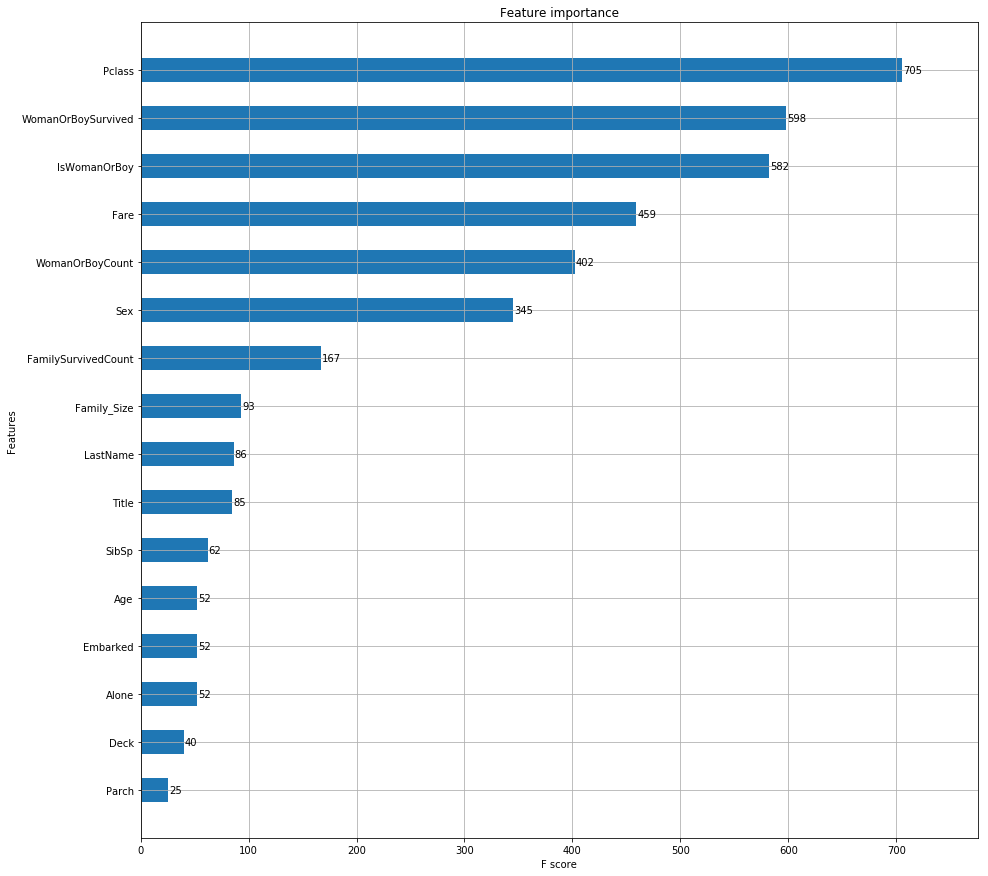

In [37]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(XGB_Classifier,ax = axes,height =0.5)
plt.show();
plt.close()

### 5.11 LGBM Classifier <a class="anchor" id="5.11"></a>

[Back to Table of Contents](#0.1)

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms. It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’. Reference [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/).

We will tuning the hyperparameters of the LGBMClassifier model using the HyperOpt and 10-fold crossvalidation

In [38]:
%%time
def hyperopt_lgb_score(params):
    clf = LGBMClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=cv_number).mean()
    print(current_score, params)
    return current_score 
 
space_lgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(4, 7, dtype=int)),
            'num_leaves': hp.choice('num_leaves', 2*np.arange(20, 2**6, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'objective': 'binary',
            'boosting_type': 'gbdt',
            }
 
best = fmin(fn=hyperopt_lgb_score, space=space_lgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.9315664622895274
{'boosting_type': 'gbdt', 'colsample_bytree': 0.96, 'learning_rate': 0.0341, 'max_depth': 5, 'min_child_weight': 3.725, 'n_estimators': 488, 'num_leaves': 106, 'objective': 'binary'}
0.9326964057923524
{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.0455, 'max_depth': 6, 'min_child_weight': 3.225, 'n_estimators': 267, 'num_leaves': 62, 'objective': 'binary'}
0.9259736639682359
{'boosting_type': 'gbdt', 'colsample_bytree': 0.635, 'learning_rate': 0.015300000000000001, 'max_depth': 6, 'min_child_weight': 4.675, 'n_estimators': 249, 'num_leaves': 116, 'objective': 'binary'}
0.9315665332168706
{'boosting_type': 'gbdt', 'colsample_bytree': 0.625, 'learning_rate': 0.039900000000000005, 'max_depth': 6, 'min_child_weight': 5.300000000000001, 'n_estimators': 340, 'num_leaves': 56, 'objective': 'binary'}
0.9349373906610676
{'boosting_type': 'gbdt', 'colsample_bytree': 0.59, 'learning_rate': 0.0483, 'max_depth': 6, 'min_child_weight': 5.800000000000001, '

In [39]:
params = space_eval(space_lgb, best)
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.635,
 'learning_rate': 0.015300000000000001,
 'max_depth': 6,
 'min_child_weight': 4.675,
 'n_estimators': 249,
 'num_leaves': 116,
 'objective': 'binary'}

In [40]:
LGB_Classifier = LGBMClassifier(**params)
LGB_Classifier.fit(train, target)
Y_pred = LGB_Classifier.predict(test).astype(int)
LGB_Classifier.score(train, target)
acc_LGB_Classifier = round(LGB_Classifier.score(train, target) * 100, 2)
acc_LGB_Classifier

96.07

In [41]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_LGB_Classifier.csv', index=False)
LB_LGB_Classifier_all = 0.82296  # old version

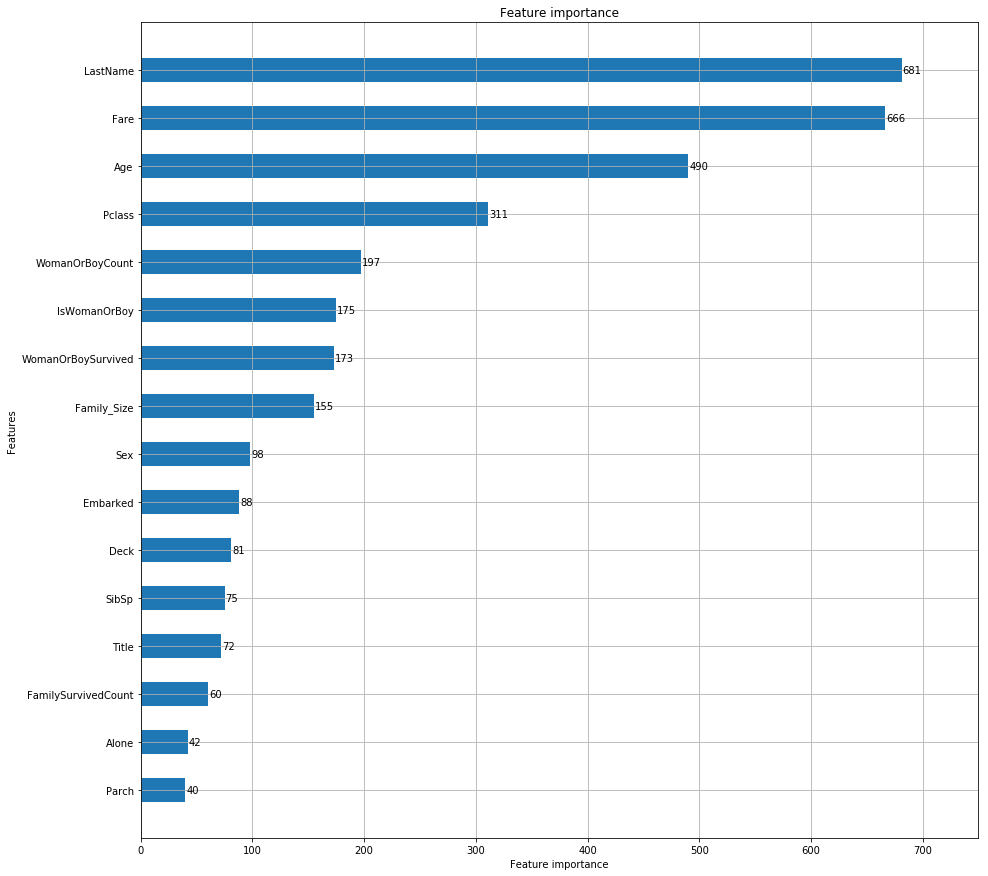

In [42]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(LGB_Classifier,ax = axes,height = 0.5)
plt.show();
plt.close()

### 5.12 GradientBoostingClassifier <a class="anchor" id="5.12"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

**Gradient Boosting** builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced. The features are always randomly permuted at each split. Therefore, the best found split may vary, even with the same training data and max_features=n_features, if the improvement of the criterion is identical for several splits enumerated during the search of the best split. To obtain a deterministic behaviour during fitting, random_state has to be fixed. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

In [43]:
%%time
def hyperopt_gb_score(params):
    clf = GradientBoostingClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=cv_number).mean()
    print(current_score, params)
    return current_score 
 
space_gb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth': hp.choice('max_depth', np.arange(5, 8, dtype=int))            
        }
 
best = fmin(fn=hyperopt_gb_score, space=space_gb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.9349372488063814
{'max_depth': 7, 'n_estimators': 412}
0.9315664622895274
{'max_depth': 6, 'n_estimators': 644}
0.9338073053035565
{'max_depth': 7, 'n_estimators': 721}
0.9371466355437486
{'max_depth': 5, 'n_estimators': 269}
0.9326837807252817
{'max_depth': 6, 'n_estimators': 271}
0.9326900577951454
{'max_depth': 6, 'n_estimators': 414}
0.9371593315381623
{'max_depth': 5, 'n_estimators': 867}
0.9338073762308996
{'max_depth': 6, 'n_estimators': 441}
0.9326837097979386
{'max_depth': 7, 'n_estimators': 632}
0.9349309008091746
{'max_depth': 7, 'n_estimators': 656}
100%|██████████| 10/10 [00:32<00:00,  3.28s/it, best loss: 0.9315664622895274]
best:
{'max_depth': 1, 'n_estimators': 544}
CPU times: user 33.2 s, sys: 72.1 ms, total: 33.2 s
Wall time: 33.2 s


In [44]:
params = space_eval(space_gb, best)
params

{'max_depth': 6, 'n_estimators': 644}

In [45]:
# Gradient Boosting Classifier

gradient_boosting = GradientBoostingClassifier(**params)
gradient_boosting.fit(train, target)
Y_pred = gradient_boosting.predict(test).astype(int)
gradient_boosting.score(train, target)
acc_gradient_boosting = round(gradient_boosting.score(train, target) * 100, 2)
acc_gradient_boosting

100.0

In [46]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_gradient_boosting.csv', index=False)
LB_GBC_all = 0.82296  # old version

### 5.13 RidgeClassifier <a class="anchor" id="5.13"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

Tikhonov Regularization, colloquially known as **Ridge Regression**, is the most commonly used regression algorithm to approximate an answer for an equation with no unique solution. This type of problem is very common in machine learning tasks, where the "best" solution must be chosen using limited data. If a unique solution exists, algorithm will return the optimal value. However, if multiple solutions exist, it may choose any of them. Reference [Brilliant.org](https://brilliant.org/wiki/ridge-regression/).

In [47]:
# Ridge Classifier

ridge_classifier = RidgeClassifier()
ridge_classifier.fit(train, target)
Y_pred = ridge_classifier.predict(test).astype(int)
ridge_classifier.score(train, target)
acc_ridge_classifier = round(ridge_classifier.score(train, target) * 100, 2)
acc_ridge_classifier

93.15

In [48]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_ridge_classifier.csv', index=False)
LB_RidgeClassifier_all = 0.80861  # old version

### 5.14 BaggingClassifier <a class="anchor" id="5.14"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

Bootstrap aggregating, also called **bagging**, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Bagging leads to "improvements for unstable procedures", which include, for example, artificial neural networks, classification and regression trees, and subset selection in linear regression. On the other hand, it can mildly degrade the performance of stable methods such as K-nearest neighbors. Reference [Wikipedia](https://en.wikipedia.org/wiki/Bootstrap_aggregating).

A **Bagging classifier** is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).

In [49]:
# Bagging Classifier

bagging_classifier = BaggingClassifier()
bagging_classifier.fit(train, target)
Y_pred = bagging_classifier.predict(test).astype(int)
bagging_classifier.score(train, target)
acc_bagging_classifier = round(bagging_classifier.score(train, target) * 100, 2)
acc_bagging_classifier

99.66

In [50]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_bagging_classifier.csv', index=False)
LB_bagging_classifier_all = 0.80861  # old version

### 5.15 ExtraTreesClassifier <a class="anchor" id="5.15"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

**ExtraTreesClassifier** implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html). 

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Extremely%20Randomized%20Trees).

In [51]:
def hyperopt_etc_score(params):
    clf = ExtraTreesClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=cv_number).mean()
    print(current_score, params)
    return current_score 
 
space_etc = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_features': hp.choice('max_features', np.arange(2, 10, dtype=int)),
            'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 5, dtype=int)),
            'max_depth':  hp.choice('max_depth', np.arange(4, 8, dtype=int)),
        }
 
best = fmin(fn=hyperopt_etc_score, space=space_etc, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.9293508694096397
{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 4, 'n_estimators': 699}
0.9372098318064449
{'max_depth': 7, 'max_features': 8, 'min_samples_leaf': 2, 'n_estimators': 181}
0.9383145961024715
{'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 3, 'n_estimators': 671}
0.9405617871137075
{'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 662}
0.9394444686779533
{'max_depth': 7, 'max_features': 4, 'min_samples_leaf': 2, 'n_estimators': 440}
0.9349626407952091
{'max_depth': 7, 'max_features': 9, 'min_samples_leaf': 2, 'n_estimators': 838}
0.932715449783973
{'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 3, 'n_estimators': 742}
0.9383208731723354
{'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 336}
0.9315981313482189
{'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 3, 'n_estimators': 191}
0.928220925906815
{'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 3, 'n_estimators': 622}
100%|███████

In [52]:
params = space_eval(space_etc, best)
params

{'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 3, 'n_estimators': 622}

In [53]:
# Extra Trees Classifier

extra_trees_classifier = ExtraTreesClassifier(**params)
extra_trees_classifier.fit(train, target)
Y_pred = extra_trees_classifier.predict(test).astype(int)
extra_trees_classifier.score(train, target)
acc_etc = round(extra_trees_classifier.score(train, target) * 100, 2)
acc_etc

93.38

In [54]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_etc.csv', index=False)
LB_ETC_all = 0.80861  # old version

### 5.16 Neural Network 1 <a class="anchor" id="5.16"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/nhlr21/complete-titanic-tutorial-with-ml-nn-ensembling

**Neural networks** are more complex and more powerful algorithm than standars machine learning, it belongs to deep learning models. To build a neural network use Keras. Keras is a high level API for tensorflow, which is a tensor-manipulation framework made by google. Keras allows you to build neural networks by assembling blocks (which are the layers of neural network). 

In [55]:
def build_ann(optimizer='adam'):
    
    # Initializing the ANN
    ann = Sequential()
    
    # Adding the input layer and the first hidden layer of the ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(16,)))
    
    # Add other layers, it is not necessary to pass the shape because there is a layer before
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # Compiling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [56]:
opt = optimizers.Adam(lr=0.001)
ann = build_ann(opt)
# Training the ANN
history = ann.fit(Xtrain, Ztrain, batch_size=16, epochs=100, validation_data=(Xval, Zval))

Train on 623 samples, validate on 268 samples
Epoch 1/100
623/623 [==============================] - 0s 748us/step - loss: 11.0590 - accuracy: 0.5457 - val_loss: 4.8565 - val_accuracy: 0.5933
Epoch 2/100
623/623 [==============================] - 0s 206us/step - loss: 5.2457 - accuracy: 0.5201 - val_loss: 2.2716 - val_accuracy: 0.6194
Epoch 3/100
623/623 [==============================] - 0s 176us/step - loss: 3.1837 - accuracy: 0.5409 - val_loss: 1.0874 - val_accuracy: 0.6530
Epoch 4/100
623/623 [==============================] - 0s 169us/step - loss: 1.6270 - accuracy: 0.5730 - val_loss: 0.7815 - val_accuracy: 0.6530
Epoch 5/100
623/623 [==============================] - 0s 166us/step - loss: 1.1755 - accuracy: 0.5827 - val_loss: 0.6427 - val_accuracy: 0.6604
Epoch 6/100
623/623 [==============================] - 0s 183us/step - loss: 0.8752 - accuracy: 0.5618 - val_loss: 0.6425 - val_accuracy: 0.6716
Epoch 7/100
623/623 [==============================] - 0s 174us/step - loss: 0.8974

In [57]:
# Predicting the Test set results
Y_pred = ann.predict(test)
Y_pred = (Y_pred > 0.5)*1 # convert probabilities to binary output

In [58]:
# Predicting the Train set results
ann_prediction = ann.predict(train)
ann_prediction = (ann_prediction > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
acc_ann1 = round(metrics.accuracy_score(target, ann_prediction) * 100, 2)
acc_ann1

90.35

In [59]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": np.reshape(Y_pred, len(Y_pred))})
#submission.to_csv('output/submission_ann1.csv', index=False)
LB_ann1_all = 0.59330  # old version

### 5.17 Neural Network 2 <a class="anchor" id="5.17"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/junheeshin/titanic-analyze-and-predict-nn

In [60]:
# Model
model = Sequential()
model.add(Dense(16, input_dim = train.shape[1], init = 'he_normal', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64, init = 'he_normal', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32, init = 'he_normal', activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 3,473
Trainable params: 3,473
Non-trainable params: 0
____________________________________________________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, input_dim=16, activation="relu", kernel_initializer="he_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="he_normal")`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="he_normal")`
  import sys


In [61]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
es = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')
hist = model.fit(train, target, batch_size=64, validation_data=(Xval, Zval), 
               epochs=500, verbose=1, callbacks=[es])

Train on 891 samples, validate on 268 samples
Epoch 1/500
891/891 [==============================] - 0s 374us/step - loss: 25.0711 - accuracy: 0.5309 - val_loss: 9.7298 - val_accuracy: 0.3806
Epoch 2/500
891/891 [==============================] - 0s 52us/step - loss: 18.0006 - accuracy: 0.5477 - val_loss: 2.6885 - val_accuracy: 0.5075
Epoch 3/500
891/891 [==============================] - 0s 51us/step - loss: 12.9629 - accuracy: 0.5387 - val_loss: 1.2955 - val_accuracy: 0.6455
Epoch 4/500
891/891 [==============================] - 0s 48us/step - loss: 12.3413 - accuracy: 0.5230 - val_loss: 3.8303 - val_accuracy: 0.4925
Epoch 5/500
891/891 [==============================] - 0s 49us/step - loss: 10.6057 - accuracy: 0.5668 - val_loss: 4.7341 - val_accuracy: 0.4925
Epoch 6/500
891/891 [==============================] - 0s 48us/step - loss: 8.8485 - accuracy: 0.5511 - val_loss: 1.0228 - val_accuracy: 0.6455
Epoch 7/500
891/891 [==============================] - 0s 56us/step - loss: 8.1929 -

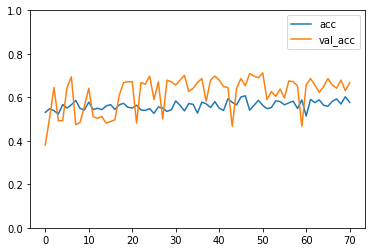

In [63]:
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
# plt.plot(hist.history['acc'], label='acc')
# plt.plot(hist.history['val_acc'], label='val_acc')
plt.ylim((0, 1))
plt.legend()

In [64]:
# Predicting the Test set results
Y_pred = model.predict(test)
Y_pred = (Y_pred > 0.5)*1 # convert probabilities to binary output

In [65]:
# Predicting the Train set results
nn_prediction = model.predict(train)
nn_prediction = (nn_prediction > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response
acc_ann2 = round(metrics.accuracy_score(target, nn_prediction) * 100, 2)
acc_ann2

61.17

In [66]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": np.reshape(Y_pred, len(Y_pred))})
#submission.to_csv('output/submission_ann2.csv', index=False)
LB_ann2_all = 0.64114  # old version

### 5.18 VotingClassifier (hard voting) <a class="anchor" id="5.18"></a>

[Back to Table of Contents](#0.1)

Thanks for the example of ensemling different models from 
https://scikit-learn.org/stable/modules/ensemble.html#Extremely%20Randomized%20Trees

The idea behind the **VotingClassifier** is to combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Voting%20Classifier).

The VotingClassifier (with **hard voting**) would classify the sample as “class 1” based on the **majority class label**. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Voting%20Classifier).

In [67]:
Voting_Classifier_hard = VotingClassifier(estimators=[('lr', logreg), ('rf', random_forest), ('gbc', gradient_boosting)], voting='hard')
for clf, label in zip([logreg, random_forest, gradient_boosting, Voting_Classifier_hard], 
                      ['Logistic Regression', 'Random Forest', 'Gradient Boosting Classifier', 'Ensemble']):
    scores = cross_val_score(clf, train, target, cv=cv_number, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.93 (+/- 0.01) [Logistic Regression]
Accuracy: 0.94 (+/- 0.02) [Random Forest]
Accuracy: 0.93 (+/- 0.02) [Gradient Boosting Classifier]
Accuracy: 0.93 (+/- 0.02) [Ensemble]


In [68]:
Voting_Classifier_hard.fit(train, target)
Y_pred = Voting_Classifier_hard.predict(test).astype(int)
Voting_Classifier_hard.score(train, target)
acc_VC_hard = round(Voting_Classifier_hard.score(train, target) * 100, 2)
acc_VC_hard

100.0

In [69]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_VC_hard.csv', index=False)
LB_VC_hard_all = 0.81339  # old version

### 5.19 VotingClassifier (soft voting) <a class="anchor" id="5.19"></a>

[Back to Table of Contents](#0.1)

Thanks for the example of ensemling different models from 
https://scikit-learn.org/stable/modules/ensemble.html#Extremely%20Randomized%20Trees

In contrast to majority voting (hard voting), **soft voting** returns the class label as argmax of the **sum of predicted probabilities**.
Specific weights can be assigned to each classifier via the weights parameter. When weights are provided, the predicted class probabilities for each classifier are collected, multiplied by the classifier weight, and averaged. The final class label is then derived from the class label with the highest average probability. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Voting%20Classifier).

In [70]:
eclf = VotingClassifier(estimators=[('lr', logreg), ('rf', random_forest), ('gbc', gradient_boosting)], voting='soft')
params = {'lr__C': [1.0, 100.0], 'gbc__learning_rate': [0.05, 1]}
Voting_Classifier_soft = GridSearchCV(estimator=eclf, param_grid=params, cv=cv_number)
Voting_Classifier_soft.fit(train, target)
Y_pred = Voting_Classifier_soft.predict(test).astype(int)
Voting_Classifier_soft.score(train, target)
acc_VC_soft = round(Voting_Classifier_soft.score(train, target) * 100, 2)
acc_VC_soft

100.0

In [71]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_VC_soft.csv', index=False)
LB_VC_soft_all = 0.81339  # old version

### 5.20 The simple rule in one line <a class="anchor" id="5.20"></a>

[Back to Table of Contents](#0.1)

Thanks to:
* https://www.kaggle.com/vbmokin/titanic-top-3-one-line-of-the-prediction-code
* https://www.kaggle.com/vbmokin/titanic-top-3-cluster-analysis
* https://www.kaggle.com/mauricef/titanic

In [72]:
Y_pred = (((test.WomanOrBoySurvived <= 0.238) & (test.Sex > 0.5) & (test.Alone > 0.5)) | \
          ((test.WomanOrBoySurvived > 0.238) & \
           ~((test.WomanOrBoySurvived > 0.55) & (test.WomanOrBoySurvived <= 0.633))))

It's solution generate tuned DecisionTreeClassifier by the GridSearchCV from kernels:
https://www.kaggle.com/vbmokin/titanic-top-3-one-line-of-the-prediction-code

In [73]:
simple_rule_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1118, splitter='best') 
simple_rule_model.fit(train, target)
Y_pred = simple_rule_model.predict(test).astype(int)
simple_rule_model.score(train, target)
acc_simple_rule = round(simple_rule_model.score(train, target) * 100, 2)
acc_simple_rule

92.7

In [74]:
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
#submission.to_csv('output/submission_simple_rule.csv', index=False)
LB_simple_rule_all = 0.83253  # old version

## 6. Tuning models and test for 3 features <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

My kernels

* [Titanic : one line of the prediction code](https://www.kaggle.com/vbmokin/titanic-top-3-one-line-of-the-prediction-code)
* [Titanic : cluster analysis](https://www.kaggle.com/vbmokin/titanic-top-3-cluster-analysis)

presents a solutions using a simple rule and only 3 features ('WomanOrBoySurvived', 'Sex', 'Alone'). Let's look at how all these models are tuned for those 3 features and whether we can find an even better solution.

In [75]:
# Preparing datasets for only 3 features ('WomanOrBoySurvived', 'Sex', 'Alone')
cols_to_drop3 = ['SibSp', 'Parch', 'Fare', 'LastName', 'Deck',
               'Pclass', 'Age', 'Embarked', 'Title', 'IsWomanOrBoy',
               'WomanOrBoyCount', 'FamilySurvivedCount', 'Family_Size']
train = train.drop(cols_to_drop3, axis=1)
test = test.drop(cols_to_drop3, axis=1)
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.3, random_state=SEED)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 3 columns):
Sex                   891 non-null int64
WomanOrBoySurvived    891 non-null float64
Alone                 891 non-null int64
dtypes: float64(1), int64(2)
memory usage: 27.8 KB


In [76]:
# 1. Logistic Regression

logreg = LogisticRegression()
logreg.fit(train, target)
Y_pred = logreg.predict(test).astype(int)
acc3_log = round(logreg.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_logreg3.csv', index=False)
LB_log = 0.77033

In [77]:
# 2. Support Vector Machines

svc = SVC()
svc.fit(train, target)
Y_pred = svc.predict(test).astype(int)
acc3_svc = round(svc.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_svm3.csv', index=False)
LB_svc = 0.79904

In [78]:
# 3. Linear SVC

linear_svc = LinearSVC(dual=False)
linear_svc.fit(train, target)
Y_pred = linear_svc.predict(test).astype(int)
acc3_linear_svc = round(linear_svc.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_linear_svc3.csv', index=False)
LB_linear_svc = 0.77033

In [79]:
# 4. k-Nearest Neighbors algorithm

knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [2, 3, 4]}, cv=cv_number).fit(train, target)
Y_pred = knn.predict(test).astype(int)
acc3_knn = round(knn.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_knn3.csv', index=False)
LB_knn = 0.77751

In [80]:
# 5. Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train, target)
Y_pred = gaussian.predict(test).astype(int)
acc3_gaussian = round(gaussian.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_GaussianNB3.csv', index=False)
LB_gaussian = 0.68899

In [81]:
# 6. Perceptron

perceptron = Perceptron()
perceptron.fit(train, target)
Y_pred = perceptron.predict(test).astype(int)
acc3_perceptron = round(perceptron.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_perceptron3.csv', index=False)
LB_perceptron = 0.77511

In [82]:
# 7. Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(train, target)
Y_pred = sgd.predict(test).astype(int)
acc3_sgd = round(sgd.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_sgd3.csv', index=False)
LB_sgd = 0.77511

In [83]:
# 8. Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
Y_pred = decision_tree.predict(test).astype(int)
acc3_decision_tree = round(decision_tree.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_decision_tree3.csv', index=False)
LB_decision_tree = 0.80382

In [84]:
# 9. Random Forest

random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [200, 300, 400, 500]}, cv=cv_number).fit(train, target)
random_forest.fit(train, target)
Y_pred = random_forest.predict(test).astype(int)
random_forest.score(train, target)
acc3_random_forest = round(random_forest.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_random_forest3.csv', index=False)
LB_random_forest = 0.80382

In [85]:
# 10. XGB_Classifier

def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=cv_number).mean()
    print(current_score, params)
    return current_score 
 
space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
            'max_depth':  hp.choice('max_depth', np.arange(4, 8, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'missing': None
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
params = space_eval(space_xgb, best)
XGB_Classifier = XGBClassifier(**params)
XGB_Classifier.fit(train, target)
Y_pred = XGB_Classifier.predict(test).astype(int)
XGB_Classifier.score(train, target)
acc3_XGB_Classifier = round(XGB_Classifier.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_XGB_Classifier3.csv', index=False)
LB_XGB_Classifier = 0.68899
print(params)

0.777744808384463
{'booster': 'gbtree', 'colsample_bytree': 0.525, 'eta': 0.45, 'eval_metric': 'auc', 'gamma': 0.935, 'learning_rate': 0.0015, 'max_depth': 4, 'min_child_weight': 7.300000000000001, 'missing': None, 'n_estimators': 948, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.995, 'tree_method': 'exact'}
0.9091068935348663
{'booster': 'gbtree', 'colsample_bytree': 0.67, 'eta': 0.315, 'eval_metric': 'auc', 'gamma': 0.665, 'learning_rate': 0.047, 'max_depth': 5, 'min_child_weight': 6.625, 'missing': None, 'n_estimators': 452, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.555, 'tree_method': 'exact'}
0.9214665150240071
{'booster': 'gbtree', 'colsample_bytree': 0.86, 'eta': 0.35000000000000003, 'eval_metric': 'auc', 'gamma': 0.875, 'learning_rate': 0.0358, 'max_depth': 6, 'min_child_weight': 6.0, 'missing': None, 'n_estimators': 408, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9400000000000001, 'tree_method': 'exact'}
0.9158484665685741
{'bo

In [86]:
# 11. LGBM_Classifier

def hyperopt_lgb_score(params):
    clf = LGBMClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=cv_number).mean()
    print(current_score, params)
    return current_score 
 
space_lgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(4, 7, dtype=int)),
            'num_leaves': hp.choice('num_leaves', 2*np.arange(20, 2**6, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'objective': 'binary',
            'boosting_type': 'gbdt',
            }
 
best = fmin(fn=hyperopt_lgb_score, space=space_lgb, algo=tpe.suggest, max_evals=10)
params = space_eval(space_lgb, best)
LGB_Classifier = LGBMClassifier(**params)
LGB_Classifier.fit(train, target)
Y_pred = LGB_Classifier.predict(test).astype(int)
LGB_Classifier.score(train, target)
acc3_LGB_Classifier = round(LGB_Classifier.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_LGB_Classifier3.csv', index=False)
LB_LGB_Classifier = 0.62200
print(params)

0.8710614312357636
{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.0083, 'max_depth': 5, 'min_child_weight': 3.575, 'n_estimators': 546, 'num_leaves': 88, 'objective': 'binary'}
0.9214665150240071
{'boosting_type': 'gbdt', 'colsample_bytree': 0.77, 'learning_rate': 0.0179, 'max_depth': 5, 'min_child_weight': 5.3500000000000005, 'n_estimators': 815, 'num_leaves': 92, 'objective': 'binary'}
0.9001495857665847
{'boosting_type': 'gbdt', 'colsample_bytree': 0.885, 'learning_rate': 0.013800000000000002, 'max_depth': 5, 'min_child_weight': 6.0, 'n_estimators': 130, 'num_leaves': 120, 'objective': 'binary'}
0.9012290290011267
{'boosting_type': 'gbdt', 'colsample_bytree': 0.53, 'learning_rate': 0.009600000000000001, 'max_depth': 6, 'min_child_weight': 1.75, 'n_estimators': 962, 'num_leaves': 90, 'objective': 'binary'}
0.9091068935348663
{'boosting_type': 'gbdt', 'colsample_bytree': 0.725, 'learning_rate': 0.019200000000000002, 'max_depth': 4, 'min_child_weight': 8.9, 'n_e

In [87]:
# 12. GradientBoostingClassifier

def hyperopt_gb_score(params):
    clf = GradientBoostingClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=cv_number).mean()
    print(current_score, params)
    return current_score 
 
space_gb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth': hp.choice('max_depth', np.arange(4, 8, dtype=int)),
            'max_features': None
        }
 
best = fmin(fn=hyperopt_gb_score, space=space_gb, algo=tpe.suggest, max_evals=5)
params = space_eval(space_gb, best)
gradient_boosting = GradientBoostingClassifier(**params)
gradient_boosting.fit(train, target)
Y_pred = gradient_boosting.predict(test).astype(int)
gradient_boosting.score(train, target)
acc3_gradient_boosting = round(gradient_boosting.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_gradient_boosting3.csv', index=False)
LB_GBC = 0.80382
print(params)

0.9214665150240071
{'max_depth': 5, 'max_features': None, 'n_estimators': 360}
0.9214665150240071
{'max_depth': 6, 'max_features': None, 'n_estimators': 324}
0.9214665150240071
{'max_depth': 6, 'max_features': None, 'n_estimators': 603}
0.9214665150240071
{'max_depth': 7, 'max_features': None, 'n_estimators': 288}
0.9214665150240071
{'max_depth': 4, 'max_features': None, 'n_estimators': 739}
100%|██████████| 5/5 [00:09<00:00,  1.92s/it, best loss: 0.9214665150240071]
{'max_depth': 5, 'max_features': None, 'n_estimators': 360}


In [88]:
# 13. Ridge Classifier

ridge_classifier = RidgeClassifier()
ridge_classifier.fit(train, target)
Y_pred = ridge_classifier.predict(test).astype(int)
ridge_classifier.score(train, target)
acc3_ridge_classifier = round(ridge_classifier.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_ridge_classifier3.csv', index=False)
LB_RidgeClassifier = 0.77511

In [89]:
# 14. Bagging Classifier

bagging_classifier = BaggingClassifier()
bagging_classifier.fit(train, target)
Y_pred = bagging_classifier.predict(test).astype(int)
bagging_classifier.score(train, target)
acc3_bagging_classifier = round(bagging_classifier.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_bagging_classifier3.csv', index=False)
LB_bagging_classifier = 0.80382

In [90]:
# 15. Extra Trees Classifier

def hyperopt_etc_score(params):
    clf = ExtraTreesClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=cv_number).mean()
    print(current_score, params)
    return current_score 
 
space_etc = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_features': hp.choice('max_features', np.arange(2, 10, dtype=int)),
            'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 5, dtype=int)),
            'max_depth':  hp.choice('max_depth', np.arange(2, 8, dtype=int)),
            'max_features': None
        }
 
best = fmin(fn=hyperopt_etc_score, space=space_etc, algo=tpe.suggest, max_evals=5)
params = space_eval(space_etc, best)
extra_trees_classifier = ExtraTreesClassifier(**params)
extra_trees_classifier.fit(train, target)
Y_pred = extra_trees_classifier.predict(test).astype(int)
extra_trees_classifier.score(train, target)
acc3_etc = round(extra_trees_classifier.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_etc3.csv', index=False)
LB_ETC = 0.79904
print(params)

0.9180957285071532
{'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 211}
0.9180957285071532
{'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'n_estimators': 719}
0.9214665150240071
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 668}
0.9180957285071532
{'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'n_estimators': 469}
0.9180957285071532
{'max_depth': 4, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 850}
100%|██████████| 5/5 [00:13<00:00,  2.70s/it, best loss: 0.9180957285071532]
{'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 211}


In [91]:
# 16. Neural Network 1 

def build_ann(optimizer='adam'):
    
    # Initializing the ANN
    ann = Sequential()
    
    # Adding the input layer and the first hidden layer of the ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(3,)))
    
    # Add other layers, it is not necessary to pass the shape because there is a layer before
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # Compiling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann
opt = optimizers.Adam(lr=0.001)
ann = build_ann(opt)
history = ann.fit(Xtrain, Ztrain, batch_size=16, epochs=100, validation_data=(Xval, Zval))
Y_pred = ann.predict(test)
Y_pred = (Y_pred > 0.5)*1 # convert probabilities to binary output
ann_prediction = ann.predict(train)
ann_prediction = (ann_prediction > 0.5)*1 # convert probabilities to binary output
acc3_ann1 = round(metrics.accuracy_score(target, ann_prediction) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": np.reshape(Y_pred, len(Y_pred))})
submission.to_csv('submission_ann1_3.csv', index=False)
LB_ann1 = 0.79904

Train on 623 samples, validate on 268 samples
Epoch 1/100
623/623 [==============================] - 0s 642us/step - loss: 0.6393 - accuracy: 0.6838 - val_loss: 0.5469 - val_accuracy: 0.7910
Epoch 2/100
623/623 [==============================] - 0s 166us/step - loss: 0.4670 - accuracy: 0.8074 - val_loss: 0.3263 - val_accuracy: 0.9030
Epoch 3/100
623/623 [==============================] - 0s 186us/step - loss: 0.2969 - accuracy: 0.8748 - val_loss: 0.2122 - val_accuracy: 0.9030
Epoch 4/100
623/623 [==============================] - 0s 175us/step - loss: 0.2476 - accuracy: 0.8925 - val_loss: 0.1987 - val_accuracy: 0.9030
Epoch 5/100
623/623 [==============================] - 0s 167us/step - loss: 0.2209 - accuracy: 0.8957 - val_loss: 0.1929 - val_accuracy: 0.9030
Epoch 6/100
623/623 [==============================] - 0s 164us/step - loss: 0.2270 - accuracy: 0.9021 - val_loss: 0.1989 - val_accuracy: 0.9142
Epoch 7/100
623/623 [==============================] - 0s 161us/step - loss: 0.2202 

In [92]:
# 17. Neural Network 2

# Model
model = Sequential()
model.add(Dense(16, input_dim = train.shape[1], init = 'he_normal', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64, init = 'he_normal', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32, init = 'he_normal', activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')
hist = model.fit(train, target, batch_size=64, validation_data=(Xval, Zval), 
               epochs=500, verbose=1, callbacks=[es])
Y_pred = model.predict(test)
Y_pred = (Y_pred > 0.5)*1 # convert probabilities to binary output
nn_prediction = model.predict(train)
nn_prediction = (nn_prediction > 0.5)*1 # convert probabilities to binary output
acc3_ann2 = round(metrics.accuracy_score(target, nn_prediction) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": np.reshape(Y_pred, len(Y_pred))})
submission.to_csv('submission_ann2_3.csv', index=False)
LB_ann2 = 0.79665

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, input_dim=3, activation="relu", kernel_initializer="he_normal")`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="he_normal")`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="he_normal")`
  if __name__ == '__main__':


Train on 891 samples, validate on 268 samples
Epoch 1/500
891/891 [==============================] - 0s 470us/step - loss: 0.6562 - accuracy: 0.6330 - val_loss: 0.5167 - val_accuracy: 0.7724
Epoch 2/500
891/891 [==============================] - 0s 71us/step - loss: 0.5283 - accuracy: 0.7262 - val_loss: 0.4046 - val_accuracy: 0.7799
Epoch 3/500
891/891 [==============================] - 0s 46us/step - loss: 0.4659 - accuracy: 0.7654 - val_loss: 0.3357 - val_accuracy: 0.8955
Epoch 4/500
891/891 [==============================] - 0s 60us/step - loss: 0.4176 - accuracy: 0.7856 - val_loss: 0.2857 - val_accuracy: 0.8955
Epoch 5/500
891/891 [==============================] - 0s 57us/step - loss: 0.3676 - accuracy: 0.8148 - val_loss: 0.2524 - val_accuracy: 0.8955
Epoch 6/500
891/891 [==============================] - 0s 49us/step - loss: 0.3430 - accuracy: 0.8182 - val_loss: 0.2312 - val_accuracy: 0.8955
Epoch 7/500
891/891 [==============================] - 0s 46us/step - loss: 0.3360 - accu

In [93]:
# 5.18 VotingClassifier (hard voting)

Voting_Classifier_hard = VotingClassifier(estimators=[('lr', logreg), ('rf', random_forest), ('gbc', gradient_boosting)], voting='hard')
for clf, label in zip([logreg, random_forest, gradient_boosting, Voting_Classifier_hard], 
                      ['Logistic Regression', 'Random Forest', 'Gradient Boosting Classifier', 'Ensemble']):
    scores = cross_val_score(clf, train, target, cv=cv_number, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
Voting_Classifier_hard.fit(train, target)
Y_pred = Voting_Classifier_hard.predict(test).astype(int)
Voting_Classifier_hard.score(train, target)
acc3_VC_hard = round(Voting_Classifier_hard.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_VC_hard3.csv', index=False)
LB_VC_hard = 0.80382

Accuracy: 0.90 (+/- 0.00) [Logistic Regression]
Accuracy: 0.92 (+/- 0.03) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Gradient Boosting Classifier]
Accuracy: 0.92 (+/- 0.03) [Ensemble]


In [94]:
# 5.19 VotingClassifier (soft voting)

eclf = VotingClassifier(estimators=[('lr', logreg), ('rf', random_forest), ('gbc', gradient_boosting)], voting='soft')
params = {'lr__C': [1.0, 100.0], 'gbc__learning_rate': [0.05, 1]}
Voting_Classifier_soft = GridSearchCV(estimator=eclf, param_grid=params, cv=cv_number)
Voting_Classifier_soft.fit(train, target)
Y_pred = Voting_Classifier_soft.predict(test).astype(int)
Voting_Classifier_soft.score(train, target)
acc3_VC_soft = round(Voting_Classifier_soft.score(train, target) * 100, 2)
submission = pd.DataFrame({"PassengerId": submission["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission_VC_soft3.csv', index=False)
LB_VC_soft = 0.80382

In [95]:
# 5.20 The simple rule in one line
Y_pred = (((test.WomanOrBoySurvived <= 0.238) & (test.Sex > 0.5) & (test.Alone > 0.5)) | \
          ((test.WomanOrBoySurvived > 0.238) & \
           ~((test.WomanOrBoySurvived > 0.55) & (test.WomanOrBoySurvived <= 0.633))))
acc3_simple_rule = acc_simple_rule
LB_simple_rule = 0.80382

## 7. Models evaluation <a class="anchor" id="7"></a>

[Back to Table of Contents](#0.1)

We can now rank our evaluation of all the models to choose the best one for our problem.

In [96]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 'k-Nearest Neighbors', 'Naive Bayes', 
              'Perceptron', 'Stochastic Gradient Decent', 
              'Decision Tree Classifier', 'Random Forest',  'XGBClassifier', 'LGBMClassifier',
              'GradientBoostingClassifier', 'RidgeClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 
              'Neural Network 1', 'Neural Network 2', 
              'VotingClassifier-hard voiting', 'VotingClassifier-soft voting',
              'Simple rule'],
    
    'Score16': [acc_log, acc_svc, acc_linear_svc, acc_knn, acc_gaussian, 
              acc_perceptron, acc_sgd, 
              acc_decision_tree, acc_random_forest, acc_XGB_Classifier, acc_LGB_Classifier,
              acc_gradient_boosting, acc_ridge_classifier, acc_bagging_classifier, acc_etc, 
              acc_ann1, acc_ann2, 
              acc_VC_hard, acc_VC_soft,
              acc_simple_rule],

    'Score3': [acc3_log, acc3_svc, acc3_linear_svc, acc3_knn, acc3_gaussian, 
              acc3_perceptron, acc3_sgd, 
              acc3_decision_tree, acc3_random_forest, acc3_XGB_Classifier, acc3_LGB_Classifier,
              acc3_gradient_boosting, acc3_ridge_classifier, acc3_bagging_classifier, acc3_etc, 
              acc3_ann1, acc3_ann2, 
              acc3_VC_hard, acc3_VC_soft,
              acc3_simple_rule],

    'LB_all': [LB_log_all, LB_svc_all, LB_linear_svc_all, LB_knn_all, LB_gaussian_all, 
              LB_perceptron_all, LB_sgd_all, 
              LB_decision_tree_all, LB_random_forest_all, LB_XGB_Classifier_all, LB_LGB_Classifier_all,
              LB_GBC_all, LB_RidgeClassifier_all, LB_bagging_classifier_all, LB_ETC_all, 
              LB_ann1_all, LB_ann2_all, 
              LB_VC_hard_all, LB_VC_soft_all,
              LB_simple_rule_all],
    
    'LB':    [LB_log, LB_svc, LB_linear_svc, LB_knn, LB_gaussian, 
              LB_perceptron, LB_sgd, 
              LB_decision_tree, LB_random_forest, LB_XGB_Classifier, LB_LGB_Classifier,
              LB_GBC, LB_RidgeClassifier, LB_bagging_classifier, LB_ETC, 
              LB_ann1, LB_ann2, 
              LB_VC_hard, LB_VC_soft,
              LB_simple_rule]})

In [97]:
models.sort_values(by=['Score16', 'LB_all', 'LB'], ascending=False)

,Model,Score16,Score3,LB_all,LB
11,GradientBoostingClassifier,100.00,92.26,0.82296,0.80382
8,Random Forest,100.00,92.26,0.81339,0.80382
17,VotingClassifier-hard voiting,100.00,92.26,0.81339,0.80382
18,VotingClassifier-soft voting,100.00,92.26,0.81339,0.80382
7,Decision Tree Classifier,100.00,92.26,0.77990,0.80382
13,BaggingClassifier,99.66,92.26,0.80861,0.80382
1,Support Vector Machines,98.99,92.14,0.62200,0.79904
10,LGBMClassifier,96.07,90.12,0.82296,0.62200
2,Linear SVC,94.61,89.45,0.81339,0.77033
9,XGBClassifier,94.39,77.78,0.80861,0.68899


In [98]:
models.sort_values(by=['Score3', 'LB_all', 'LB'], ascending=False)

,Model,Score16,Score3,LB_all,LB
19,Simple rule,92.70,92.70,0.83253,0.80382
11,GradientBoostingClassifier,100.00,92.26,0.82296,0.80382
8,Random Forest,100.00,92.26,0.81339,0.80382
17,VotingClassifier-hard voiting,100.00,92.26,0.81339,0.80382
18,VotingClassifier-soft voting,100.00,92.26,0.81339,0.80382
13,BaggingClassifier,99.66,92.26,0.80861,0.80382
7,Decision Tree Classifier,100.00,92.26,0.77990,0.80382
14,ExtraTreesClassifier,93.38,92.14,0.80861,0.79904
1,Support Vector Machines,98.99,92.14,0.62200,0.79904
15,Neural Network 1,90.35,92.14,0.59330,0.79904


In [99]:
models.sort_values(by=['LB_all', 'LB', 'Score3'], ascending=False)

,Model,Score16,Score3,LB_all,LB
19,Simple rule,92.70,92.70,0.83253,0.80382
11,GradientBoostingClassifier,100.00,92.26,0.82296,0.80382
10,LGBMClassifier,96.07,90.12,0.82296,0.62200
8,Random Forest,100.00,92.26,0.81339,0.80382
17,VotingClassifier-hard voiting,100.00,92.26,0.81339,0.80382
18,VotingClassifier-soft voting,100.00,92.26,0.81339,0.80382
2,Linear SVC,94.61,89.45,0.81339,0.77033
13,BaggingClassifier,99.66,92.26,0.80861,0.80382
14,ExtraTreesClassifier,93.38,92.14,0.80861,0.79904
12,RidgeClassifier,93.15,89.56,0.80861,0.77511


In [100]:
models.sort_values(by=['LB', 'LB_all', 'Score3'], ascending=False)

,Model,Score16,Score3,LB_all,LB
19,Simple rule,92.70,92.70,0.83253,0.80382
11,GradientBoostingClassifier,100.00,92.26,0.82296,0.80382
8,Random Forest,100.00,92.26,0.81339,0.80382
17,VotingClassifier-hard voiting,100.00,92.26,0.81339,0.80382
18,VotingClassifier-soft voting,100.00,92.26,0.81339,0.80382
13,BaggingClassifier,99.66,92.26,0.80861,0.80382
7,Decision Tree Classifier,100.00,92.26,0.77990,0.80382
14,ExtraTreesClassifier,93.38,92.14,0.80861,0.79904
1,Support Vector Machines,98.99,92.14,0.62200,0.79904
15,Neural Network 1,90.35,92.14,0.59330,0.79904


## 8. Conclusion <a class="anchor" id="8"></a>

[Back to Table of Contents](#0.1)

- The best model is the **simple rule in one line** from ["Titanic Top 3% : one line of the prediction code"](https://www.kaggle.com/vbmokin/titanic-top-3-one-line-of-the-prediction-code). Surprisingly, that the simple rule in one line gives the best result. This once again proves the enormous value of features engineering. The optimal selection of features is the key to success!

- Models **GradientBoostingClassifier, Random Forests, VotingClassifiers, BaggingClassifier, Decision Tree Classifier** have provided the same accuracy LB on the test dataset as the simple rule, although on the training dataset they are much more accurate up to 100%.

- The **VotingClassifier** for both voting options ("*hard*" and "*soft*") aggregation gave the same result for all the variants of features, that is, the solution found is indeed optimal, although a **Logistic Regression**, which is not one of the best, was selected for voting. This confirms the high efficiency of this method of aggregating (ensembling) predictions.

- The models **GradientBoostingClassifier, BaggingClassifier, Random Forests, VotingClassifiers** did a good job of optimizing the features themselves, providing comparable accuracy for the different number of features in the test dataset, but the models **Decision Tree Classifier, Stochastic Gradient Descent, Support Vector Machines, Perceptron, Neural Networks, k-Nearest Neighbors algorithm** are very sensitive to the feature sets, because the accuracy of LB_all and LB is very different. Models **XGB Classifier, LGBM Classifier, ExtraTreesClassifier, Logistic Regression, Linear SVC, Naive Bayes, RidgeClassifier** depend on FE, but not so significantly.

- The methods **LGBM Classifier, Perceptron, Neural Networks, Linear SVC, Naive Bayes, Logistic Regression, k-Nearest Neighbors algorithm, RidgeClassifier** have low accuracy LB, especially methods **Naive Bayes, Logistic Regression, Linear SVC**, compared to other models, although the "***Titanic: Machine Learning from Disaster***" contest is not indicative for the machine learning tasks because it contains too little data.

- In all models, except **LGBM Classifier, Linear SVC, RidgeClassifier, Logistic Regression, Naive Bayes**, the prediction of test dataset based on 3 features yielded a more accurate result, possibly because these models perform worse under conditions of low number of features or under conditions of significant data dependence (in fact, feature "*WomanOrBoySurvived*" is, in part derived from others features "*Sex*" and "*Alone*") or with a small number of points (millions of points may vary greatly). Particularly interesting is that the **LGBM Classifier** model and method gave comparatively low accuracy on both the training and test datasets for the variant with three features, unlike **XGB Classifier** and other decision tree-based methods in which LB > LB_all.

- To increase the accuracy of predictions, its need to increase the number of features and further improve their processing, that is FE (for example, add the processed feature "**Tickets**" - context is consist of a good kernels with have examples of such processing (["Advanced Feature Engineering Tutorial with Titanic"](https://www.kaggle.com/gunesevitan/advanced-feature-engineering-tutorial-with-titanic) etc.).

I hope you find this kernel useful and enjoyable.

Your comments and feedback are most welcome.

[Go to Top](#0)